In [1]:
%env KERAS_BACKEND=torch

env: KERAS_BACKEND=torch


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Embedding, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re

In [3]:
nltk.download('stopwords')
snow_stemmer = SnowballStemmer(language='english')

[nltk_data] Downloading package stopwords to /home/radu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Global variables
image_size = (100, 100)
embedding_dim = 256
lstm_units = 256
batch_size = 32
num_classes = 2

### Loading images

In [5]:
def load_images(folder_path):
    """Load and preprocess images from a folder."""
    image_data = []
    for folder in folder_path:
        files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
        for file_name in tqdm(files, desc=f"Loading images from folder {folder}"):
            file_path = os.path.join(folder, file_name)
            img = Image.open(file_path)
            if img.mode != "RGB":
                img = img.convert("RGB")
            img = img.resize(image_size)
            img_arr = np.array(img) / 255.0  # Normalize
            image_data.append(img_arr)
    return np.array(image_data)

### Preprocess text

In [6]:
def preprocess_captions(captions):
    """Preprocess captions by removing stopwords, punctuation, and stemming."""
    stop_words = set(stopwords.words('english'))
    processed_captions = []
    for sentence in captions:
        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
        tokens = word_tokenize(sentence)
        tokens = [snow_stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words]
        processed_captions.append(' '.join(tokens))
    return processed_captions

In [7]:

def map_words_to_ids(captions):
    """Map unique words in captions to unique IDs."""
    mapped_ids = {}
    k = 0
    for sentence in captions:
        for word in sentence.split():
            if word not in mapped_ids:
                mapped_ids[word] = k
                k += 1
    return mapped_ids

In [8]:
def encode_captions(captions, word_map):
    """Encode captions into sequences of IDs, dynamically adding new words."""
    for caption in captions:
        for word in caption.split():
            if word not in word_map:
                word_map[word] = len(word_map)  # Add new word to the map
    return [[word_map[word] for word in caption.split()] for caption in captions]


In [9]:

def align_image_features(image_features, df):
    """Align image features based on image IDs in the dataset."""
    unique_image_ids = df['image_id'].unique()
    image_id_to_index = {img_id: idx for idx, img_id in enumerate(unique_image_ids)}
    aligned_features = [image_features[image_id_to_index[img_id]] for img_id in df['image_id']]
    return np.array(aligned_features)

In [10]:
def build_cnn_model():
    """Build a CNN model for image feature extraction."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(100, 100, 3)))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    return model

In [11]:
def extract_image_features(image_data, model):
    """Extract features from images using the CNN model."""
    #feature_extractor = Sequential(model.layers[:-1])
    return model.predict(image_data)

In [12]:
def build_lstm_model(vocab_size, max_length):
    """Build an LSTM model for text feature extraction."""
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    return model

In [13]:
def train_combined_model(x_train, y_train, x_val, y_val):
    """Train a dense model on combined features."""
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)
    return model

In [14]:
# Load datasets
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')

# Load and preprocess images
train_image_data = load_images(['./train_images'])
val_image_data = load_images(['./val_images'])

Loading images from folder ./val_images: 100%|██████████| 2957/2957 [00:00<00:00, 4708.79it/s]


In [15]:
# Build and extract image features
cnn_model = build_cnn_model()
train_image_features = extract_image_features(train_image_data, cnn_model)
val_image_features = extract_image_features(val_image_data, cnn_model)
np.save('train_image_features.npy', train_image_features)
np.save('val_image_features.npy', val_image_features)

/home/radu/miniforge3/envs/ML/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [16]:
# Preprocess captions
train['processed_caption'] = preprocess_captions(train['caption'])
val['processed_caption'] = preprocess_captions(val['caption'])
test['processed_caption'] = preprocess_captions(test['caption'])


# Combine training and validation captions for mapping
all_captions = list(train['processed_caption']) + list(val['processed_caption']) + list(test['processed_caption'])
# Map words to IDs
mapped_ids = map_words_to_ids(all_captions)

# Encode captions
train_caption_ids = encode_captions(train['processed_caption'], mapped_ids)
val_caption_ids = encode_captions(val['processed_caption'], mapped_ids)

# Pad sequences
max_length = max([len(seq) for seq in train_caption_ids])
train_padded = pad_sequences(train_caption_ids, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_caption_ids, maxlen=max_length, padding='post')


In [17]:
# Build and extract text features
vocab_size = len(mapped_ids)
lstm_model = build_lstm_model(vocab_size, max_length)
train_lstm_features = lstm_model.predict(train_padded)
val_lstm_features = lstm_model.predict(val_padded)
np.save('train_lstm_features.npy', train_lstm_features)
np.save('val_lstm_features.npy', val_lstm_features)

  3/313 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step 

/home/radu/miniforge3/envs/ML/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


In [18]:
# Align image features to captions
train_aligned_image_features = align_image_features(train_image_features, train)
val_aligned_image_features = align_image_features(val_image_features, val)

In [19]:
# Combine features
train_combined_features = np.concatenate((train_aligned_image_features, train_lstm_features), axis=1)
val_combined_features = np.concatenate((val_aligned_image_features, val_lstm_features), axis=1)

# One-hot encode labels
train_labels = to_categorical(train['label'].values, num_classes=num_classes)
val_labels = to_categorical(val['label'].values, num_classes=num_classes)

train_labels_binary = np.argmax(train_labels, axis=1)  # Convert one-hot to binary labels
val_labels_binary = np.argmax(val_labels, axis=1)


In [20]:
# Train model
model = train_combined_model(train_combined_features, train_labels_binary, val_combined_features, val_labels_binary)

Epoch 1/10
  8/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4448 - loss: 0.6948  

/home/radu/miniforge3/envs/ML/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4903 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5057 - loss: 0.6936 - val_accuracy: 0.5003 - val_loss: 0.6937
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5018 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5023 - loss: 0.6941 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5023 - val_loss: 0.6938
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5243 - loss: 0.6918 - val_accuracy: 0.4990 - val_loss: 0.6932
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5139 - loss: 0.6931 - val_accuracy: 0.5043 - val_loss: 0.6937
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5118 - loss: 0.6927 - val_accuracy: 0.5097 - val_

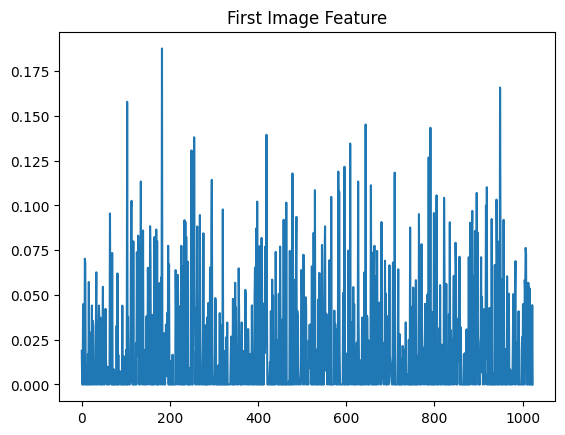

In [21]:
# Visualize the first image feature
import matplotlib.pyplot as plt

plt.plot(train_image_features[0])
plt.title("First Image Feature")
plt.show()


In [22]:
# Print the first text feature
print("First text feature vector:", train_lstm_features[0])

First text feature vector: [0.         0.00845172 0.         ... 0.00101284 0.         0.        ]


In [20]:
# Preprocess test captions
test['processed_caption'] = preprocess_captions(test['caption'])

# Encode test captions with updated `mapped_ids`
test_caption_ids = encode_captions(test['processed_caption'], mapped_ids)

# Pad sequences for LSTM
test_padded = pad_sequences(test_caption_ids, maxlen=max_length, padding='post')

# Extract test LSTM features
test_lstm_features = lstm_model.predict(test_padded)

# Load and preprocess test images
test_image_data = load_images(['./test_images'])
test_image_features = extract_image_features(test_image_data, cnn_model)

# Align test image features with test.csv
test_aligned_image_features = align_image_features(test_image_features, test)

# Combine test features
test_combined_features = np.concatenate((test_aligned_image_features, test_lstm_features), axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


Loading images from folder ./test_images: 100%|██████████| 1978/1978 [00:00<00:00, 3395.01it/s]


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [23]:
# Make predictions
test_predictions = model.predict(test_combined_features)

# Convert probabilities to binary labels
test_labels = (test_predictions > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [24]:
# Create submission
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['label'] = test_labels  # Update 'label' column with predictions

# Save submission file
submission_path = 'submission.csv'
sample_submission.to_csv(submission_path, index=False)

print(f"Submission file created: {submission_path}")

Submission file created: submission.csv
